In [ ]:
# -*- coding:utf-8 -*-
# time:2018/5/3 上午9:26
# author:ZhaoH
from __future__ import division, print_function, absolute_import
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.callbacks import (EarlyStopping,
                             ModelCheckpoint, TensorBoard)
import pickle as pkl
from data_prepare.data_generator import *
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.optimizers import *
from keras import regularizers

# hardminning

In [1]:
# -*- coding:utf-8 -*-
# time:2018/5/3 上午9:26
# author:ZhaoH
from __future__ import division, print_function, absolute_import
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.callbacks import (EarlyStopping,
                             ModelCheckpoint, TensorBoard)
import pickle as pkl
from data_prepare.data_generator import *
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.optimizers import *
from keras import regularizers
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()  
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
session = tf.Session(config=config)

# 设置session
KTF.set_session(session)


#tune2
def cnn_model():
    model = Sequential()
    # block1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv1', input_shape=(14, 14, 1)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # block2
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='block2_conv1'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    return model
'''
#tune3
def cnn_model():
    model = Sequential()
    # block1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1', input_shape=(14, 14, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv5', input_shape=(14, 14, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv6', input_shape=(14, 14, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv7', input_shape=(14, 14, 1)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    # block2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2'))
    #model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    #model.add(GlobalAveragePooling2D())

    return model
'''
def get_cnn_model(num_classes):
    model = cnn_model()
    # fnn
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='dense2'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model


'''

def get_cnn_model(num_classes):
    model = cnn_model()
    # fnn
    model.add(Flatten())
    
    #model.add(Dense(256, activation='relu', name='dense1'))
    #model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', name='dense2'))
    model.add(Dropout(0.1))
    #model.add(Dense(128, activation='relu', name='dense3'))
    #model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model
'''
def train_model(num_classes):
    # get input
    filepath = 'data/cnn_train/'#由data——generation.py生成
    #batch_size = 32   256good
    batch_size = 256
    num_classes = num_classes
    image_reader = ImageReader(filepath, batch_size=batch_size,
                               partition=[0.6, 0.2, 0.2], method=2,
                               norm='z_score')
    train_dict = image_reader.train_batch()
    test_dict = image_reader.test_batch()
    val_dict = image_reader.val_batch()
    x_train = np.array(train_dict['image'])
    y_train = np.array(train_dict['label'])
    x_val = np.array(val_dict['image'])
    y_val = np.array(val_dict['label'])
    x_test = np.array(test_dict['image'])
    y_test = np.array(test_dict['label'])

    # load weight
    new_model = get_cnn_model(num_classes)
    checkpoint = ModelCheckpoint('cnn_weight/Time_cnn_all_gap_slice_0.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
    tb = TensorBoard(log_dir='graph/Time_cnn_all_gap_slice_0', write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    
    # train
    adam = Adam(lr=0.0001, decay=1e-6)
    adam2=Adam(lr=0.0005, beta_1=0.9, beta_2=0.99)

    #optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #new_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mse', metrics=['accuracy'])
    new_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    print('x_train.shape: ', x_train.shape)
    print('y_train.shape: ', y_train.shape)
    print('x_val.shape: ', x_val.shape)
    new_model.fit(x_train, y_train, batch_size=batch_size, epochs=30, shuffle=True,
                  validation_data=(x_val, y_val), callbacks=callbacks_list)
    new_model.load_weights('cnn_weight/Time_cnn_all_gap_slice_0.h5')
    #new_model.save_weights('cnn_weight/zk_weight.h5')
    new_model.save_weights('cnn_weight/zk_weight_total_tune4.h5')
    # test hard_minning困难样本

    image_reader1 = ImageReader(filepath, batch_size=batch_size,
                            partition=[1.0, 0.0, 0.0], method=2,
                            norm='z_score')
    train_dict = image_reader1.train_batch()
    x_all = np.array(train_dict['image'])
    y_all = np.array(train_dict['label'])

    score = new_model.evaluate(x_test, y_test, batch_size=256)
    pred = new_model.predict(x_all, batch_size=256)
    #save_file = 'result/cnn_result/Time_cnn_all_gap_slice_0.pkl'
    save_file = 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune4_hardminning.pkl'
    with open(save_file, 'wb') as sf:
        pkl.dump({'pred': pred, 'label': y_test}, sf)
    print(pred.shape)
    print(y_test.shape)

    print('test loss:', score[0])
    print('test acc:', score[1])


def normalize(data, norm='z_score'):
    """
    对数据进行归一化，data 是要归一化的数据，shape = (28,28,3), norm 是归一化的方式
    :param data:
    :param norm:
    :return:
    """
    norm_paras_file = os.path.join('data_prepare/max_min_mean_std_new.pkl')
    with open(norm_paras_file, 'rb') as file:
        paras = pickle.load(file)  # {filename:[max, min, mean, std] }
        for key in paras.keys():
            if 'petrel_Time_gain_attr' in key:
                Cur_paras = paras.get(key)
                break
    if norm == 'z_score':
        image = (data - Cur_paras[2]) / Cur_paras[3]
    elif norm == 'min_max':
        image = (data - Cur_paras[1]) / (Cur_paras[0] - Cur_paras[1])
    elif norm == 'grey':
        image = np.array((data - Cur_paras[1]) / (Cur_paras[0] - Cur_paras[1]) * 255, dtype=np.int)
    return image


def turn_into_specific_channel(image, method, norm='z_score'):
    image = normalize(image, norm=norm)
    if method == 3:
        return image
    elif method == 1:
        temp = np.zeros(shape=(14 * 2, 14 * 2))
        temp[:14, :14] = image[:, :, 0]
        temp[:14, 14:] = image[:, :, 1]
        temp[14:, :14] = image[:, :, 2]
        return temp.reshape((14 * 2, 14 * 2, 1))
    elif method == 2:
        #time切片

        temp = np.zeros(shape=(14, 14))
        temp[:14, :14] = image[:, :, 0]
        return temp.reshape((14, 14, 1))  

        '''
        #line切片
        temp = np.zeros(shape=(14, 14))
        temp[:14, :14] = image[:, :, 1]
        return temp.reshape((14, 14, 1))

        #cdp切片
        temp = np.zeros(shape=(14, 14))
        temp[:14, :14] = image[:, :, 2]
        return temp.reshape((14, 14, 1))
        '''
def get_data(data_set, method, norm='z_score'):
    data_set = np.array(data_set)
    data_new = []
    count = 0
    for cur_image in data_set:
        count += 1
        print('get_data_rate: ', float(count / len(data_set)))
        tmp_image = turn_into_specific_channel(cur_image, method, norm=norm)
        data_new.append(tmp_image)

    return np.array(data_new)


def get_data_batch(data_set, batch_size, method, norm='z_score'):
    data_set = np.array(data_set)
    data_set = get_data(data_set, method, norm=norm)
    batch_num = int(len(data_set) / batch_size)
    for batch_i in range(batch_num+1):
        if batch_i == batch_num:
            x_batch = data_set[batch_i*batch_size:]
        else:
            start_i = batch_i * batch_size
            x_batch = data_set[start_i:start_i + batch_size]

        yield x_batch


    
if __name__ == '__main__':
    train_model(2)
    #pred_model(2)#zk
    #train_model(2)#zkd
    #pred_time(2)#hhhhhhzk



Using TensorFlow backend.
/disk2/zk/sw/Anaconda2/envs/py77/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/disk2/zk/sw/Anaconda2/envs/py77/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/disk2/zk/sw/Anaconda2/envs/py77/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/disk2/zk/sw/Anaconda2/env

initializing...
_data_neg
_data_pos





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


x_train.shape:  (38325, 14, 14, 1)
y_train.shape:  (38325, 2)
x_val.shape:  (19183, 14, 14, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 38325 samples, validate on 19183 samples


Epoch 1/30
38325/38325 [==============================] - 5s 143us/step - loss: 0.6866 - acc: 0.5739 - val_loss: 0.6765 - val_acc: 0.5950

Epoch 00001: val_loss improved from inf to 0.67646, saving model to cnn_weight/Time_cnn_all_gap_slice_0.h5
Epoch 2/30
38325/38325 [==============================] - 3s 83us/step - loss: 0.6710 - acc: 0.5712 - val_loss: 0.6698 - val_acc: 0.5821

Epoch 00002: val_loss improved from 0.67646 to 0.66979, saving model to cnn_weight/Time_cnn_all_gap_slice_0.h5
Epoch 3/30
38325/38325 [==============================] - 3s 84us/step - loss: 0.6543 - acc: 0.5904 - val_

In [1]:
import pickle as pkl
import numpy as np
file_dir1 = 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune4_hardminning.pkl'
#file_dir1 = 'result/cnn_result/Time_pred_slice_1_52.pkl'
res,res1=None,None
with open(file_dir1, 'rb') as f1:
    data_1 = pkl.load(f1)
    res1=np.array(data_1['pred'].T[1])
#     res2=np.array(data_1['pred'].T[1])
    res=res1[(res1>0.4 )&(res1<0.6)]
print(len(res))
print(len(res1))
print(sum(res1>0.0))
# print(np.where((res1>0.4 )&(res1<0.6)))
hard_pos=np.where((res1>0.4 )&(res1<0.6))
print(hard_pos)
print(res1[np.where((res1>0.4 )&(res1<0.6))])
# res==res1[np.where((res1>0.4 )&(res1<0.6))]

22530
69208
69208
(array([   39,    40,    41, ..., 69202, 69203, 69204]),)
[0.4646622  0.44722557 0.47777155 ... 0.45880464 0.4388962  0.42399627]


In [5]:
filepath = 'data/cnn_train/'#由data——generation.py生成
batch_size = 256

image_reader1 = ImageReader(filepath, batch_size=batch_size,
                        partition=[1.0, 0.0, 0.0], method=2,
                        norm='z_score')
train_dict = image_reader1.train_batch()
x_all = np.array(train_dict['image'])
y_all = np.array(train_dict['label'])

initializing...
_data_neg
_data_pos


In [6]:
hard_pos=list(hard_pos[0])

TypeError: 'numpy.int64' object is not iterable

In [23]:
x_all[hard_pos]

array([[[[-0.71453686],
         [-0.82564119],
         [-0.75303762],
         ...,
         [-0.92843058],
         [-1.05476581],
         [-0.96148426]],

        [[-0.98437648],
         [-0.99484307],
         [-0.90972348],
         ...,
         [-0.99643571],
         [-1.00004573],
         [-0.90285983]],

        [[-1.33128517],
         [-1.40001099],
         [-1.14791805],
         ...,
         [-0.84873174],
         [-0.7685088 ],
         [-0.68531857]],

        ...,

        [[-0.53840263],
         [-0.52054184],
         [-0.55130797],
         ...,
         [-0.49708235],
         [-0.19797608],
         [ 0.03129019]],

        [[-0.61442796],
         [-0.24743646],
         [-0.24965858],
         ...,
         [-0.53502662],
         [-0.53513455],
         [-0.59405299]],

        [[-0.61848786],
         [-0.51976609],
         [ 0.14589233],
         ...,
         [-0.66064151],
         [-0.66356623],
         [-0.74379503]]],


       [[[-0.70631601],


In [26]:
import pandas as pd
import os

In [27]:
well_sample_file = os.path.join('data/1-well/samplint_points_total.csv')
samplint_points_total=pd.read_csv(well_sample_file)

In [101]:
hard_sample=samplint_points_total.iloc[hard_pos]
# hard_sample['well_no']=hard_sample['well_no'].astype('str')
hard_sample_pos=hard_sample[hard_sample['is_reservoir']==1][['line','cdp','time']]
hard_sample_neg=hard_sample[hard_sample['is_reservoir']==0][['line','cdp','time']]
well_no1=np.array(hard_sample[hard_sample['is_reservoir']==1]['well_no'])
well_no2=np.array(hard_sample[hard_sample['is_reservoir']==0]['well_no'])

9071+13459
hard_sample
# well_no1.shape

,well_no,line,cdp,time,is_reservoir
39,CB111,1253,1309,429,1
40,CB111,1253,1309,430,1
41,CB111,1253,1309,431,1
42,CB111,1253,1309,432,1
58,CB111,1253,1309,446,0
...,...,...,...,...,...
69177,SHHG3,1353,1617,1099,1
69201,SHHG3,1353,1617,1123,1
69202,SHHG3,1353,1617,1124,1
69203,SHHG3,1353,1617,1125,1


fdfd


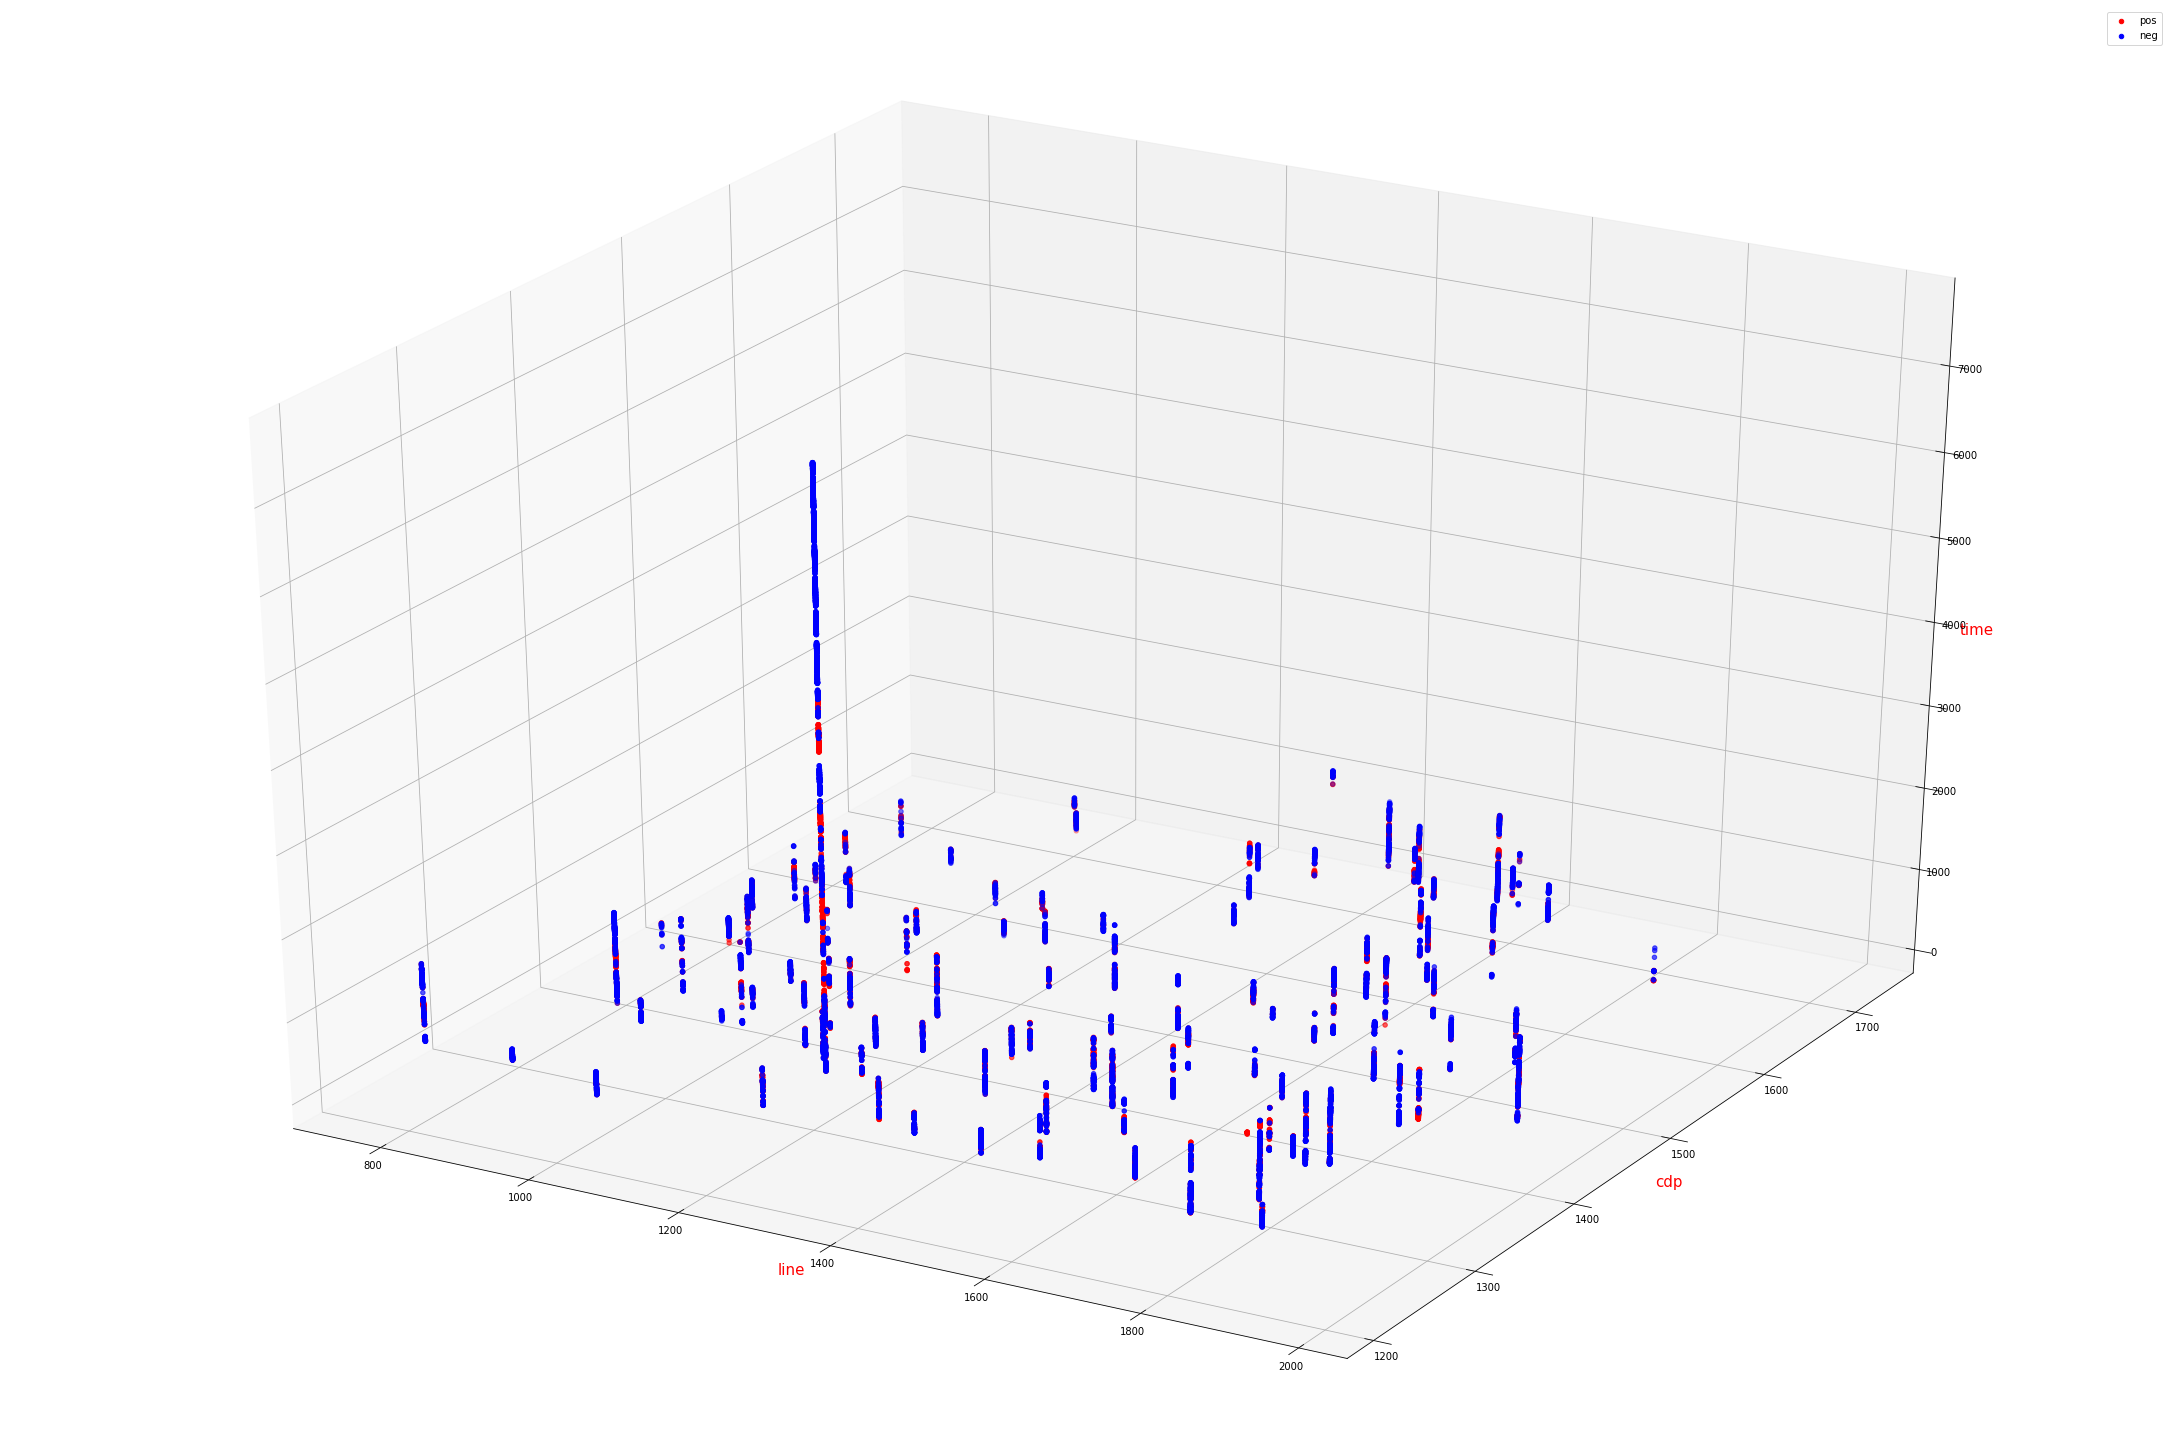

In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 空间三维画图
 
# 数据１
data1 = np.array(hard_sample_pos)
# data的值如下：
# [[ 0  1  2]
#  [ 3  4  5]
#  [ 6  7  8]
#  [ 9 10 11]
#  [12 13 14]
#  [15 16 17]
#  [18 19 20]
#  [21 22 23]]
x1 = data1[:, 0]  # [ 0  3  6  9 12 15 18 21]
y1 = data1[:, 1]  # [ 1  4  7 10 13 16 19 22]
z1 = data1[:, 2]  # [ 2  5  8 11 14 17 20 23]
well1=well_no1
# 数据２
data2 = np.array(hard_sample_neg)
x2 = data2[:, 0]
y2 = data2[:, 1]
z2 = data2[:, 2]
well2=well_no2
# 绘制散点图
fig = plt.figure(figsize=(30,20))
ax = Axes3D(fig)
ax.scatter(x1, y1, z1, c='r',s=20,  label='pos')
ax.scatter(x2, y2, z2, c='b',s=20,  label='neg')
 
# 绘制图例
ax.legend(loc='best')
 
# 添加坐标轴(顺序是Z, Y, X)
ax.set_zlabel('time', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('cdp', fontdict={'size': 15, 'color': 'red'})
ax.set_xlabel('line', fontdict={'size': 15, 'color': 'red'})


# for i in range(len(data1)):
#     ax.text(x1[i],y1[i],z1[i],i)
# for i in range(len(data2)):
#     ax.text(x2[i],y2[i],z2[i],i)


print("fdfd")
# 展示
plt.show()
# plt.savefig('hardsample.pdf')
# plt.savefig('hardsample.png')